In [1]:
#  Upload ZIP
from google.colab import files

# This opens a file picker in Colab — pick your local ZIP file
uploaded = files.upload()

Saving images.zip to images.zip


In [2]:
#Extract ZIP
import zipfile
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall('images/')

In [3]:
#Verify
import os
# Should list: ['sunflower', 'dalmatian', ...]
print("Folders found:", os.listdir('images/images'))

Folders found: ['sunflower', 'pizza', 'dalmatian', 'soccer_ball', 'dollar_bill']


In [4]:
print("Example files in 'sunflower':", os.listdir('images/images/sunflower')[:5])


Example files in 'sunflower': ['image_0075.jpg', 'image_0062.jpg', 'image_0053.jpg', 'image_0066.jpg', 'image_0042.jpg']


In [5]:
#Import libraries
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
# Correct base path
base_path = 'images/images/'

X = []
y = []

for label in os.listdir(base_path):
    class_path = os.path.join(base_path, label)
    if os.path.isdir(class_path):
        for img_file in sorted(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path).convert('RGB').resize((64, 64))
                img_array = np.array(img) / 255.0
                X.append(img_array)
                y.append(label)
            except:
                print("Could not load:", img_path)

print(f"Loaded {len(X)} images.")

Loaded 309 images.


In [7]:
X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_flat = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Shape of X:", X.shape)
print("Classes:", le.classes_)
print("Train set:", X_train.shape, "Test set:", X_test.shape)

Shape of X: (309, 64, 64, 3)
Classes: ['dalmatian' 'dollar_bill' 'pizza' 'soccer_ball' 'sunflower']
Train set: (247, 12288) Test set: (62, 12288)


**Model Training**

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2] }

In [9]:
#Create Random Forest model
rf = RandomForestClassifier(random_state=42)

In [12]:
# Wrap it in GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                   # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)

In [13]:
#Fit to training data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [14]:
#Get best model & params
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


**Evaluation**



In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Make predictions
y_pred = best_rf.predict(X_test)

In [16]:
#Basic accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.7419


In [17]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

   dalmatian       0.63      0.86      0.73        14
 dollar_bill       0.86      0.60      0.71        10
       pizza       0.64      0.70      0.67        10
 soccer_ball       0.88      0.64      0.74        11
   sunflower       0.82      0.82      0.82        17

    accuracy                           0.74        62
   macro avg       0.76      0.72      0.73        62
weighted avg       0.76      0.74      0.74        62



In [18]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

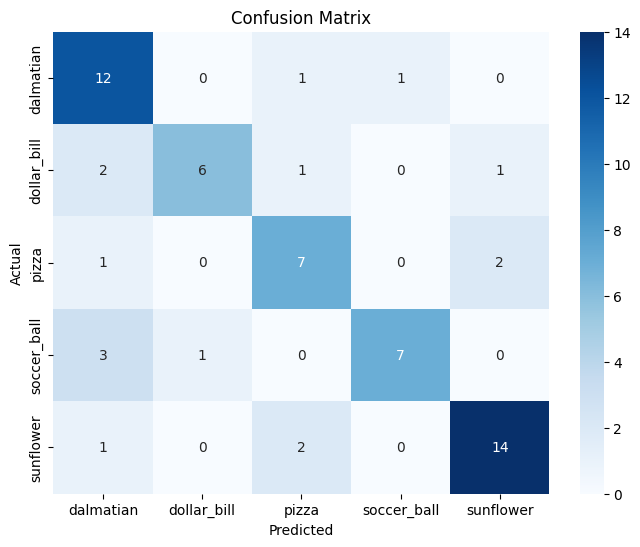

In [19]:
# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:
*   dalmatian row: 12 images were correctly predicted as dalmatian. 1 was wrongly predicted as pizza. 1 as soccer_ball.
*   dollar_bill row: 6 correct predictions. 2 were confused with dalmatian. 1 misclassified as pizza, 1 as sunflower.
*   soccer_ball row: 7 correct, 3 misclassified as dalmatian, 1 as dollar_bill.
*   pizza row: 7 correct, 1 confused with dalmatian, 2 confused with sunflower.
*   sunflower row: 14 correct, 1 confused with dalmatian, 2 confused with pizza.

**Feature Importance Visualization**

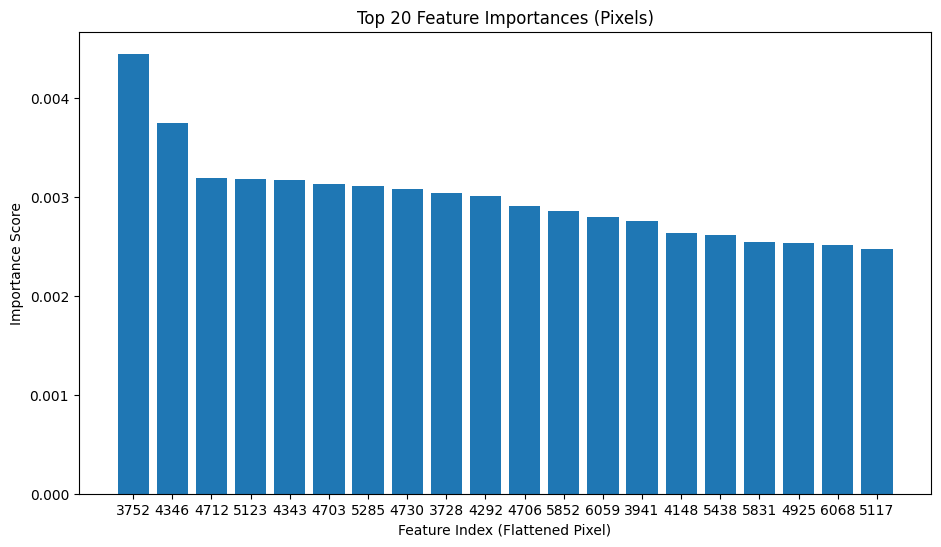

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#Get feature importances
importances = best_rf.feature_importances_

#Sort and get top 20 features
indices = np.argsort(importances)[::-1]  # Descending sort
top_n = 20

plt.figure(figsize=(11,6))
plt.title("Top 20 Feature Importances (Pixels)")
plt.bar(range(top_n), importances[indices[:top_n]], align='center')
plt.xticks(range(top_n), indices[:top_n])
plt.xlabel("Feature Index (Flattened Pixel)")
plt.ylabel("Importance Score")
plt.show()


**Prediction on New Image**

In [29]:
from PIL import Image
import numpy as np

#Function to preprocess and predict a new image
def predict_new_image(img_path, model, label_encoder):

    #Load and resize
    img = Image.open(img_path).convert('RGB').resize((64, 64))

    #Convert to array and normalize
    img_array = np.array(img) / 255.0

    #Flatten to 1D
    img_flat = img_array.reshape(1, -1)

    #Predict
    prediction = model.predict(img_flat)

    #Decode label
    predicted_class = label_encoder.inverse_transform(prediction)

    return predicted_class[0]

#Example usage
new_image_path = 'images/images/sunflower/image_0075.jpg'
predicted_label = predict_new_image(new_image_path, best_rf, le)
print(f"Predicted class: {predicted_label}")


Predicted class: pizza
